In [57]:
import pandas as pd
from datetime import datetime

import matplotlib.pyplot as plt
import datetime

import numpy as np
import os
from pandas.plotting import table

map_data_tier_id = {
 "31224": "MINIAODSIM",
 "81": "FEVT",
 "183": "RECODEBUG",
 "2051": "NANOEDMAODSIM",
 "211946": "PREMIXRAW",
 "1": "RAW",
 "6": "RECO",
 "205": "RAWDEBUG",
 "2061891": "PREMIX",
 "163": "FEVTHLTALL",
 "9": "AOD",
 "8": "USER",
 "241": "ALCAPROMPT",
 "7": "ALCARECO",
 "31223": "MINIAOD",
 "361": "DQMROOT",
 "2056891": "NANOAOD",
 "125": "RAW-RECO",
 "464": "RAWRECOSIMHLT",
 "21": "AODSIM",
 "323": "RAW-HLT",
 "141": "FEVTDEBUGHLT",
 "106": "DIGI-RECO",
 "2051891": "RAWAODSIM",
 "201": "DQM",
 "31517": "DQMIO",
 "215856": "PREMIX-RAW",
 "2056892": "NANOAODSIM",
 "401": "LHE",
 "115": "GEN-SIM-DIGI-RAW-HLTDEBUG-RECO",
 "285": "GEN-SIM-RAW-HLT",
 "122": "GEN-SIM-RECO",
 "225": "GEN-SIM-DIGI-RECODEBUG",
 "206": "GEN-SIM-RAWDEBUG",
 "3": "GEN",
 "120": "GEN-SIM-RAW-HLTDEBUG-RECO",
 "117": "GEN-SIM-DIGI-RECO",
 "112": "GEN-SIM-DIGI-HLTDEBUG-RECO",
 "383": "GEN-RAWDEBUG",
 "114": "GEN-SIM-DIGI-RAW-HLTDEBUG",
 "446": "GEN-SIM-RAW-HLTDEBUG-RECODEBUG",
 "343": "GEN-RAW",
 "113": "GEN-SIM-DIGI-RAW",
 "121": "GEN-SIM-RAW-RECO",
 "109": "GEN-SIM",
 "110": "GEN-SIM-DIGI",
 "116": "GEN-SIM-DIGI-RAW-RECO",
 "119": "GEN-SIM-RAW-HLTDEBUG",
 "118": "GEN-SIM-RAW",
 "184": "GEN-SIM-RECODEBUG"
}

In [58]:
def make_window_sum(series, window_in_day):
    item_sum = []
    for i, _ in enumerate(series):
        item_tmp = 0
        if i > window:
            for j in range(window):
                item_tmp += series[i-j]
            #print item_tmp
        item_sum.append(item_tmp)

    return pd.Series(data=item_sum, index=series.index)

# time window in days for plots of working sets
window = 30

In [113]:
# AVAILABLE DATASETS:
# ws_all_18.pkl.gz
# ws_T2_IT_18.pkl.gz
# ws_T2_US_18.pkl.gz
# ws_T2_ES_18.pkl.gz
# ws_T2_DE_18.pkl.gz
# ws_T2_FR_18.pkl.gz
#
# Until 2019-04:
# ws_all_19.pkl.gz
# ws_T2_IT_19.pkl.gz
# ws_T2_US_19.pkl.gz
# ws_T2_ES_19.pkl.gz
# ws_T2_DE_19.pkl.gz
# ws_T2_FR_19.pkl.gz

name = 'T2_US_18'

with open('mkdir.sh', 'w') as ostream:
    ostream.write("""#!/bin/bash
mkdir -p %s""" % name)

!source ./mkdir.sh
# Period of time
## 2018
start_date = datetime.datetime(2017,12,31)
end_date = datetime.datetime(2018,12,31)
total_hrs = (datetime.datetime(2018,12,31) - datetime.datetime(2017,12,31)).days*24
## 2019
#start_date = datetime.datetime(2018,12,31)
#end_date = datetime.datetime(2019,4,30)
#total_hrs = (end_date - start_date).days*24

data = pd.read_pickle('ws_%s.pkl.gz' % name)

data.set_index('day', inplace=True)
data = data.sort_index()

data = data.dropna(subset=['CMSSite'])

data['ExitCode'] = data.apply(lambda x: 0 if x['Chirp_CRAB3_Job_ExitCode']== 0 else 1, axis=1)

data['data_label'] = data.apply(lambda x: map_data_tier_id["%s" % x['data_tier']], axis=1 )

ignore_overflow = (data[(data['InputData']=='Offsite') & (data['OverflowType']!='IgnoreLocality')].WallClock.sum() == 0.0)

print "Ignore overflow:", ignore_overflow
print data.columns
print data.Type.size

Ignore overflow: False
Index([u'CRAB_DataBlock', u'Type', u'CMSSite', u'CRAB_Workflow',
       u'CRAB_UserHN', u'OVERFLOW_CHECK', u'JobStatus', u'JobCpus',
       u'InputData', u'data_tier', u'block_size', u'OverflowType',
       u'Chirp_CRAB3_Job_ExitCode', u'WallClock', u'CPUTime', u'CoreTime',
       u'ExitCode', u'data_label'],
      dtype='object')
1380315


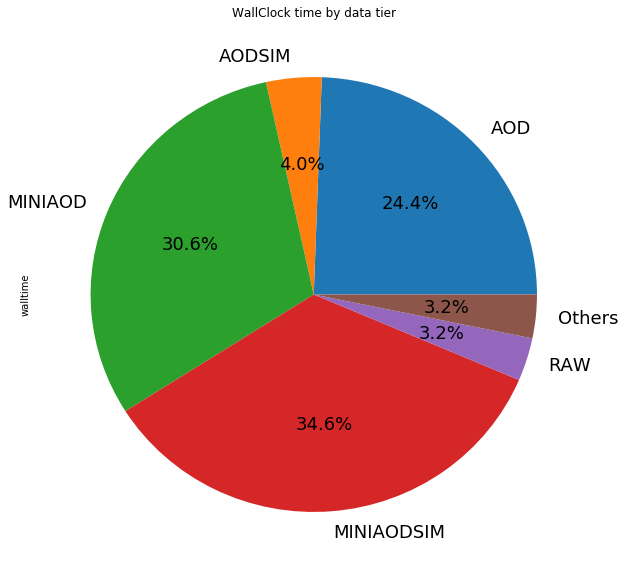

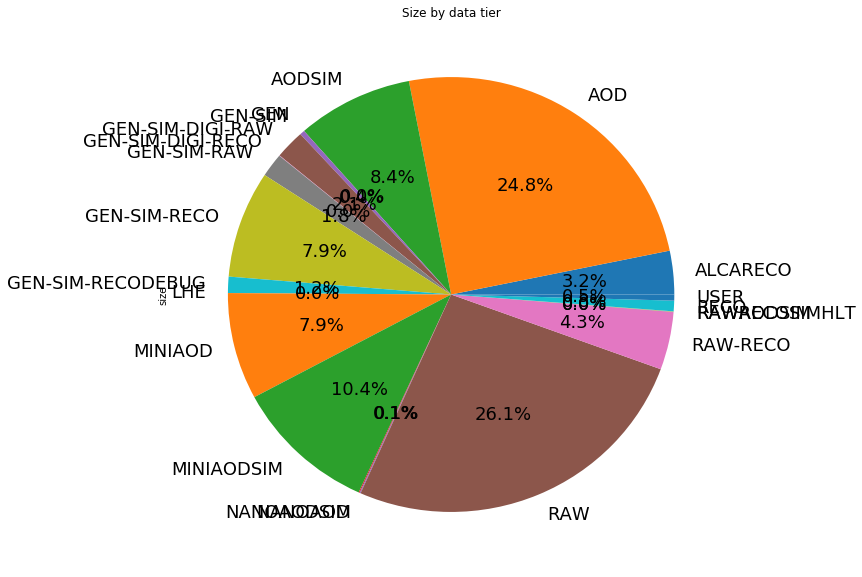

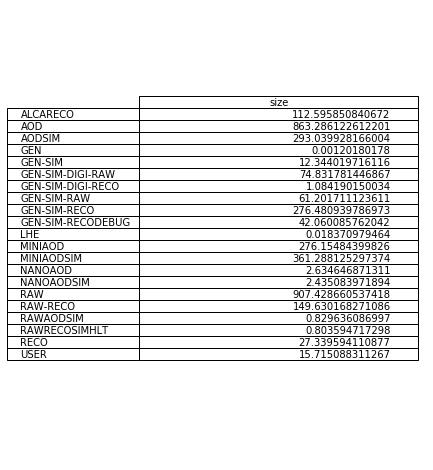

In [114]:
wc_series = data.groupby('data_label').apply(lambda x: x['WallClock'].sum())
wc_tier = pd.DataFrame({'walltime': wc_series.values}, index=wc_series.index)

sum_wc = data.WallClock.sum()
wall_other = wc_tier[wc_tier['walltime']/sum_wc <= 0.03].walltime.sum()
wall_show = wc_tier[wc_tier['walltime']/sum_wc > 0.03].walltime

wc_tier = pd.DataFrame({'walltime': np.append(wall_show.values,[wall_other])},
                       index=np.append(wall_show.index, ["Others"]))

wc_tier.plot.pie(y='walltime', title='WallClock time by data tier', autopct='%1.1f%%', figsize=(10, 10), fontsize=18, legend=False)
plt.savefig('%s/wallClock_time_by_data_tier.png' % name)
plt.show()

wc_series = data.drop_duplicates(subset=['block_size']).groupby('data_label').apply(lambda x: x['block_size'].sum())
wc_tier = pd.DataFrame({'size': wc_series.values}, index=wc_series.index)

#print wc_tier/1E12

wc_tier.plot.pie(y='size', title='Size by data tier', autopct='%1.1f%%', figsize=(10, 10), fontsize=18, legend=False)
plt.savefig('%s/size_by_data_tier.png' % name)
plt.show()

plt.figure(figsize=(5, 8))
ax2 = plt.subplot(111)
plt.axis('off')
tbl = table(ax2, wc_tier/1e12, loc='center')
tbl.auto_set_font_size(True)
#tbl.set_fontsize(10)

plt.savefig('%s/size_by_data_tier_table.png' % name)

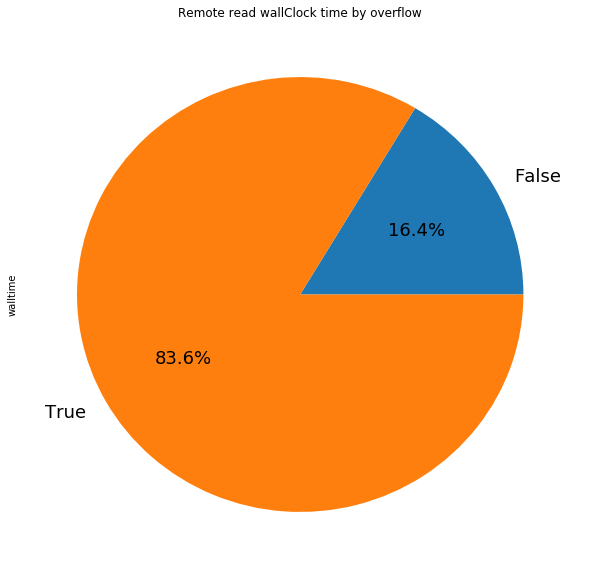

In [115]:
plot_series = data[data['InputData']=='Offsite'].groupby('OVERFLOW_CHECK').apply(lambda x: x['WallClock'].sum())
wc_remote_by_overflow = pd.DataFrame({'walltime': plot_series.values}, index=plot_series.index)

wc_remote_by_overflow.plot.pie(y='walltime', title='Remote read wallClock time by overflow', autopct='%1.1f%%', figsize=(10, 10), fontsize=18, legend=False)
plt.savefig('%s/remote_time_by_overflow.png' % name)
plt.show()


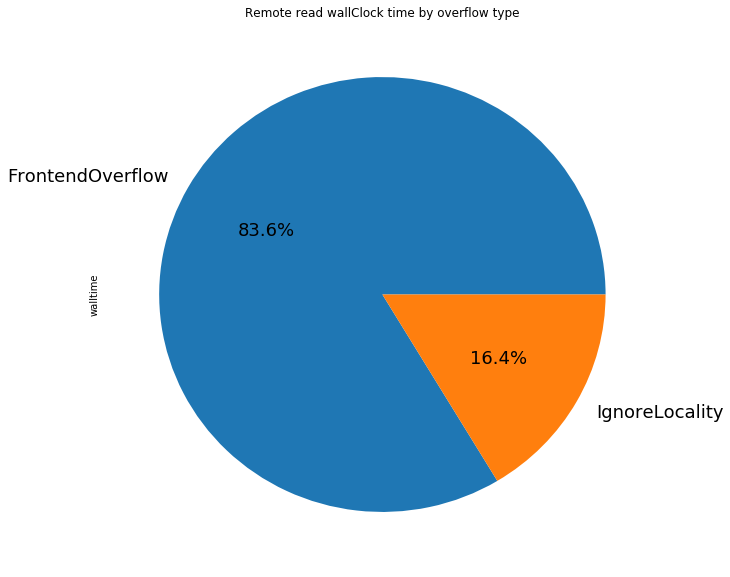

In [116]:
plot_series = data[data['InputData']=='Offsite'].groupby('OverflowType').apply(lambda x: x['WallClock'].sum())
wc_remote_by_overflow_type = pd.DataFrame({'walltime': plot_series.values}, index=plot_series.index)

wc_remote_by_overflow_type.plot.pie(y='walltime', title='Remote read wallClock time by overflow type', autopct='%1.1f%%', figsize=(10, 10), fontsize=18, legend=False)
plt.savefig('%s/remote_time_by_overflow_type.png' % name)
plt.show()

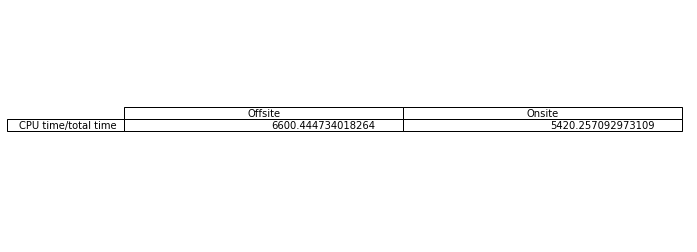

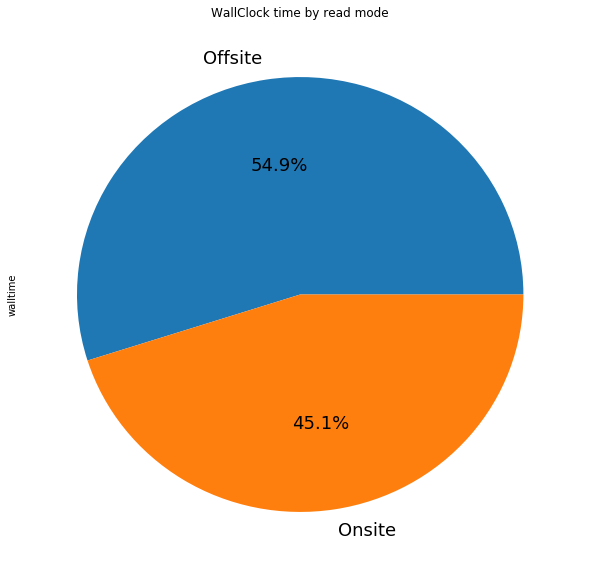

In [117]:
plot_series = data.groupby('InputData').apply(lambda x: x['WallClock'].sum())

cpu_equivalent = pd.DataFrame({'Onsite': plot_series.Onsite/total_hrs, 'Offsite': plot_series.Offsite/total_hrs},
                           index=["CPU time/total time"])

plt.figure(figsize=(10, 4))
ax2 = plt.subplot(111)
plt.axis('off')
tbl = table(ax2, cpu_equivalent, loc='center')
tbl.auto_set_font_size(True)
#tbl.set_fontsize(10)

plt.savefig('%s/cpu_equivalent_table.png' % name)


wc_remote_vs_local = pd.DataFrame({'walltime': plot_series.values}, index=plot_series.index)

wc_remote_vs_local.plot.pie(y='walltime', title='WallClock time by read mode', autopct='%1.1f%%', figsize=(10, 10), fontsize=18, legend=False)

#print "CPU equivalent Offsite:", plot_series.Offsite/total_hrs
#print "CPU equivalent Onsite:", plot_series.Onsite/total_hrs

plt.savefig('%s/time_by_read_mode.png' % name)
plt.show()




<Figure size 720x864 with 0 Axes>

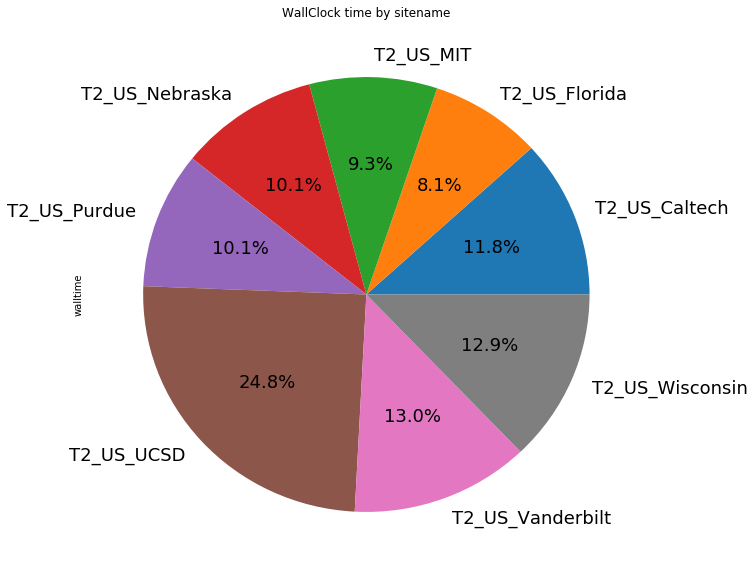

In [118]:
plot_series = data.groupby('CMSSite').apply(lambda x: x['WallClock'].sum())

wc_by_sitename = pd.DataFrame({'walltime': plot_series.values}, index=plot_series.index)


sum_wc = data.dropna(subset=['CMSSite']).WallClock.sum()
none_wc = data.WallClock.sum()
wall_other = wc_by_sitename[(wc_by_sitename['walltime']/sum_wc) <= 0.02].walltime.sum()
wall_show = wc_by_sitename[(wc_by_sitename['walltime']/sum_wc) > 0.02].walltime

import numpy as np
#print sum_wc

if wall_other > 0:
    wc_by_sitename = pd.DataFrame({'walltime': np.append(wall_show.values,[wall_other, none_wc-sum_wc])},
                           index=np.append(wall_show.index, ["Others", "Unknown"]))

plt.figure(figsize=(10, 12))
wc_by_sitename.plot.pie(y='walltime', title='WallClock time by sitename', autopct='%1.1f%%', figsize=(10, 10), fontsize=18, legend=False)
plt.savefig('%s/time_by_sitee.png' % name)
plt.show()

CPU equivalent 0: 9642.712117738456
CPU equivalent 1: 2377.9897092529172


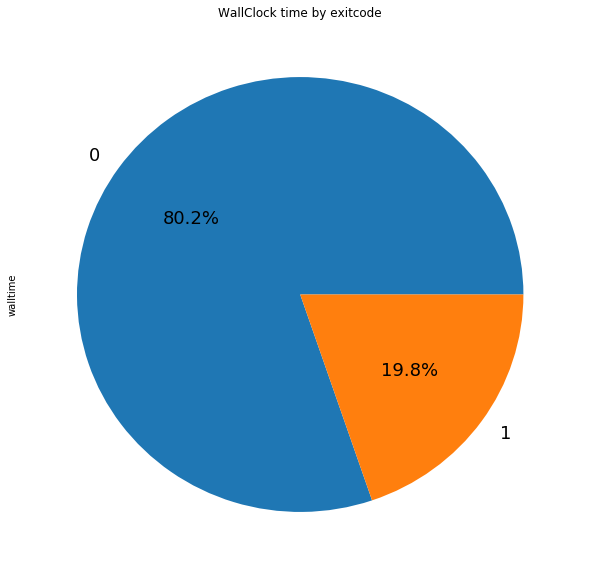

In [119]:
plot_series = data.groupby('ExitCode').apply(lambda x: x['WallClock'].sum())

wc_by_exitcode = pd.DataFrame({'walltime': plot_series.values}, index=plot_series.index)

wc_by_exitcode.plot.pie(y='walltime', title='WallClock time by exitcode', autopct='%1.1f%%', figsize=(10, 10), fontsize=18, legend=False)

print "CPU equivalent 0:", plot_series[0]/total_hrs
print "CPU equivalent 1:", plot_series[1]/total_hrs

plt.savefig('%s/time_by_exitcode.png' % name)
plt.show()

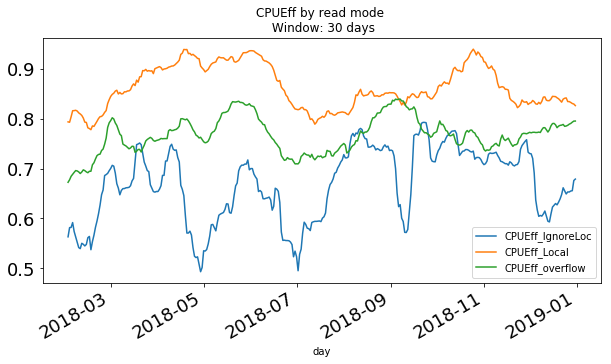

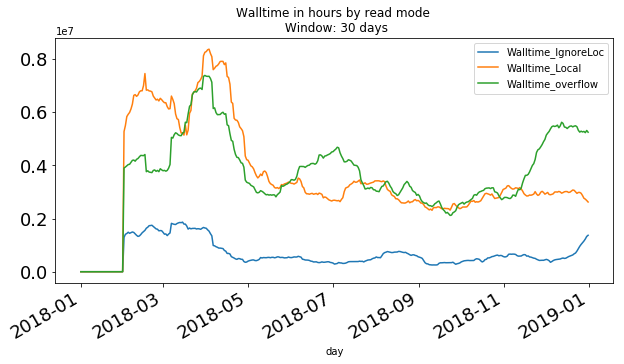

In [120]:
if not ignore_overflow:
    serie = data[(data['ExitCode']>=0.0) & (data['InputData']=="Offsite") & (data['OverflowType']!='IgnoreLocality')].groupby('day').WallClock.sum()
    wall_off = make_window_sum(serie, window)


    serie = data[(data['ExitCode']>=0.0) & (data['InputData']=="Offsite") & (data['OverflowType']!='IgnoreLocality')].groupby('day').CPUTime.sum()
    cpu_off = make_window_sum(serie, window)


serie = data[(data['ExitCode']>=0.0) & (data['InputData']=="Offsite") & (data['OverflowType']=='IgnoreLocality')].groupby('day').WallClock.sum()
wall_ign = make_window_sum(serie, window)

serie = data[(data['ExitCode']>=0.0) & (data['InputData']=="Offsite") & (data['OverflowType']=='IgnoreLocality')].groupby('day').CPUTime.sum()
cpu_ign = make_window_sum(serie, window)


serie = data[(data['ExitCode']>=0.0) & (data['InputData']=="Onsite")].groupby('day').WallClock.sum()
wall = make_window_sum(serie, window)

serie = data[(data['ExitCode']>=0.0) & (data['InputData']=="Onsite")].groupby('day').CPUTime.sum()
cpu = make_window_sum(serie, window)

if not ignore_overflow:
    cpu_eff_off = (cpu_off/wall_off).reindex(cpu.index, method='bfill', fill_value=0)

cpu_eff_ign = (cpu_ign/wall_ign).reindex(cpu.index, method='bfill', fill_value=0)

cpu_eff_loc = (cpu/wall).reindex(cpu.index, method='bfill', fill_value=0)

if not ignore_overflow:
    cpu_eff = pd.DataFrame({'CPUEff_overflow': cpu_eff_off.values, 
                            'CPUEff_IgnoreLoc': cpu_eff_ign.values, 
                            'CPUEff_Local': cpu_eff_loc.values}, 
                           index=cpu.index)
else:
        cpu_eff = pd.DataFrame({
                            'CPUEff_IgnoreLoc': cpu_eff_ign.values, 
                            'CPUEff_Local': cpu_eff_loc.values}, 
                           index=cpu.index)

cpu_eff.plot(title='CPUEff by read mode \n Window: %s days' % window, figsize=(10, 5), fontsize=18, x_compat=True)

plt.savefig('%s/CPUEff_%sd_window_by_read_mode.png' % (name,window))
plt.show()

if not ignore_overflow:
    wall_off = wall_off.reindex(wall.index, method='bfill', fill_value=0)
wall_ign = wall_ign.reindex(wall.index, method='bfill', fill_value=0)
wall_loc = wall.reindex(wall.index, method='bfill', fill_value=0)

if not ignore_overflow:
    wall_plot = pd.DataFrame({'Walltime_overflow': wall_off.values, 
                            'Walltime_IgnoreLoc': wall_ign.values, 
                            'Walltime_Local': wall_loc.values}, 
                           index=wall.index)
else:
    wall_plot = pd.DataFrame({
                            'Walltime_IgnoreLoc': wall_ign.values, 
                            'Walltime_Local': wall_loc.values}, 
                           index=wall.index)

wall_plot.plot(title='Walltime in hours by read mode \n Window: %s days' % window, figsize=(10, 5), fontsize=18, x_compat=True)

plt.savefig('%s/Walltime-hrs_%sd_window_by_read_mode.png' % (name,window))
plt.show()

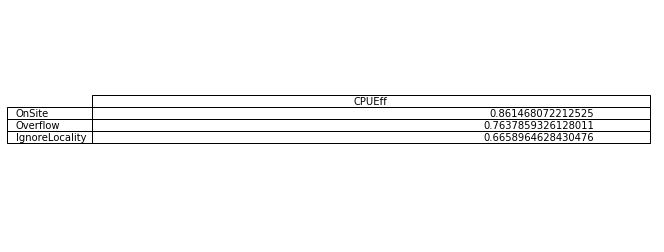

<Figure size 720x720 with 0 Axes>

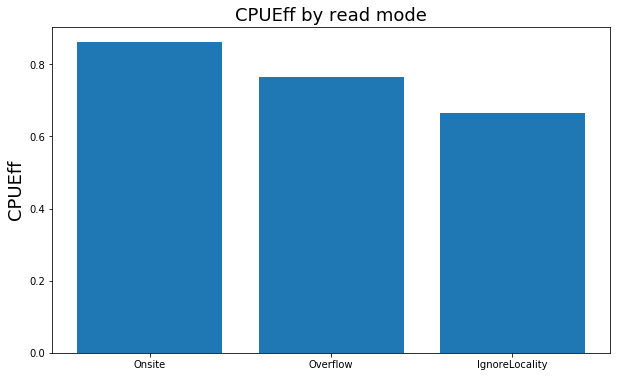

In [121]:
wall_ign = data[(data['ExitCode']>=0.0) & (data['InputData']=="Offsite") & (data['OverflowType']=='IgnoreLocality')].WallClock.sum()
cpu_ign = data[(data['ExitCode']>=0.0) & (data['InputData']=="Offsite") & (data['OverflowType']=='IgnoreLocality')].CPUTime.sum()

#print "CPUEff Offsite IgnoreLocality:\t", cpu_ign/wall_ign

if not ignore_overflow:
    wall_off = data[(data['ExitCode']>=0.0) & (data['InputData']=="Offsite") & (data['OverflowType']!='IgnoreLocality')].WallClock.sum()
    cpu_off = data[(data['ExitCode']>=0.0) & (data['InputData']=="Offsite") & (data['OverflowType']!='IgnoreLocality')].CPUTime.sum()

    #print "CPUEff Offsite Overflow:\t", cpu_off/wall_off

wall = data[(data['ExitCode']>=0.0) & (data['InputData']=="Onsite")].WallClock.sum()
cpu = data[(data['ExitCode']>=0.0) & (data['InputData']=="Onsite")].CPUTime.sum()

#print "CPUEff Onsite:\t\t\t", cpu/wall

if not ignore_overflow:
    cpu_eff_table = pd.DataFrame({'CPUEff': [cpu/wall, cpu_off/wall_off, cpu_ign/wall_ign]},
                           index=["OnSite", "Overflow", "IgnoreLocality"])
else:
    cpu_eff_table = pd.DataFrame({'CPUEff': [cpu/wall, cpu_ign/wall_ign]},
                           index=["OnSite", "IgnoreLocality"])

plt.figure(figsize=(10, 4))
ax2 = plt.subplot(111)
plt.axis('off')
tbl = table(ax2, cpu_eff_table, loc='center')
tbl.auto_set_font_size(True)
#tbl.set_fontsize(10)

plt.savefig('%s/cpueff_by_read_mode_table.png' % name)

plt.figure(figsize=(10, 10))
if not ignore_overflow:
    plt.figure(figsize=(10, 6))
    plt.bar(["Onsite", "Overflow", "IgnoreLocality"],[cpu/wall,cpu_off/wall_off, cpu_ign/wall_ign ])
    plt.ylabel('CPUEff',fontdict={"fontsize":18})
    plt.title('CPUEff by read mode',fontdict={"fontsize":18})
    plt.savefig('%s/cpueff_by_read_mode.png' % name)
    plt.show()
else:
    plt.figure(figsize=(10, 6))
    plt.bar(["Onsite", "IgnoreLocality"],[cpu/wall, cpu_ign/wall_ign ])
    plt.ylabel('CPUEff',fontdict={"fontsize":18})
    plt.title('CPUEff by read mode',fontdict={"fontsize":18})
    plt.savefig('%s/cpueff_by_read_mode.png' % name)
    plt.show()


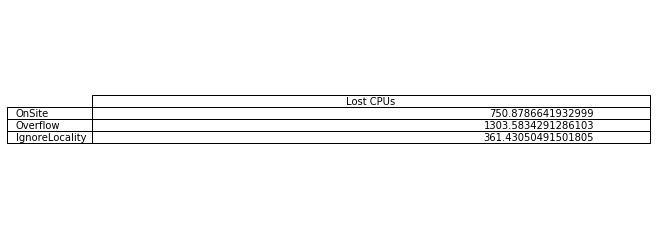

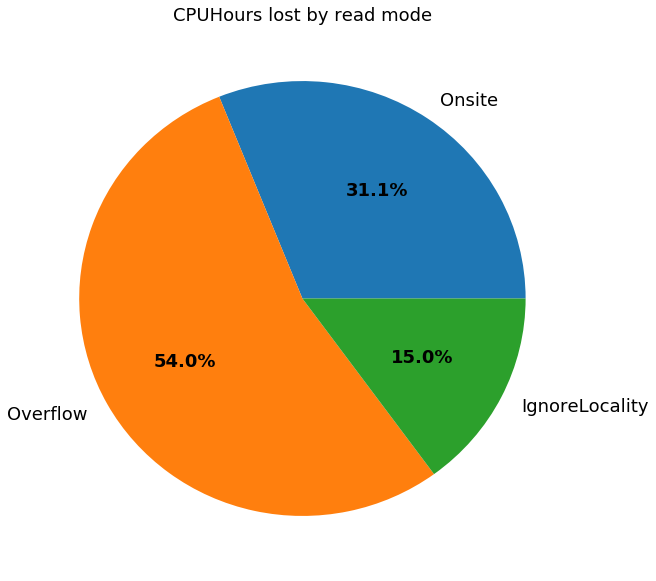

In [122]:
# CPU loss
# histo cpu eff
wall_ign = data[(data['ExitCode']>=0.0) & (data['InputData']=="Offsite") & (data['OverflowType']=='IgnoreLocality')].WallClock.sum()
cpu_ign = data[(data['ExitCode']>=0.0) & (data['InputData']=="Offsite") & (data['OverflowType']=='IgnoreLocality')].CPUTime.sum()

#print "CPULoss Offsite IgnoreLocality:\t", (wall_ign - cpu_ign)

if not ignore_overflow:
    wall_off = data[(data['ExitCode']>=0.0) & (data['InputData']=="Offsite") & (data['OverflowType']!='IgnoreLocality')].WallClock.sum()
    cpu_off = data[(data['ExitCode']>=0.0) & (data['InputData']=="Offsite") & (data['OverflowType']!='IgnoreLocality')].CPUTime.sum()

    #print "CPULoss Offsite Overflow:\t", (wall_off - cpu_off)

wall = data[(data['ExitCode']>=0.0) & (data['InputData']=="Onsite")].WallClock.sum()
cpu = data[(data['ExitCode']>=0.0) & (data['InputData']=="Onsite")].CPUTime.sum()

#print "CPULoss Onsite:\t\t\t", (wall - cpu)/total_hrs

if not ignore_overflow:
    lost_cpus_table = pd.DataFrame({'Lost CPUs': [(wall - cpu)/total_hrs, (wall_off - cpu_off)/total_hrs ,(wall_ign - cpu_ign)/total_hrs]},
                           index=["OnSite", "Overflow","IgnoreLocality"])
else:
    lost_cpus_table = pd.DataFrame({'Lost CPUs': [(wall - cpu)/total_hrs ,(wall_ign - cpu_ign)/total_hrs]},
                           index=["OnSite", "IgnoreLocality"])    

plt.figure(figsize=(10, 4))
ax2 = plt.subplot(111)
plt.axis('off')
tbl = table(ax2, lost_cpus_table, loc='center')
tbl.auto_set_font_size(True)
#tbl.set_fontsize(10)

plt.savefig('%s/lost_cpus_by_read_mode_table.png' % name)



plt.figure(figsize=(10, 10))
if not ignore_overflow:
    wedges, texts, autotexts = plt.pie([(wall-cpu), (wall_off-cpu_off), (wall_ign-cpu_ign)], labels=["Onsite", "Overflow", "IgnoreLocality"], autopct='%1.1f%%', textprops={"fontsize":18})
else:
    wedges, texts, autotexts = plt.pie([(wall-cpu), (wall_ign-cpu_ign)], labels=["Onsite", "IgnoreLocality"], autopct='%1.1f%%', textprops={"fontsize":18})
    
plt.setp(texts, size=18)
plt.setp(autotexts, size=18, weight="bold")
plt.title('CPUHours lost by read mode',fontdict={"fontsize":18})

plt.savefig('%s/lost_cpus_by_read_mode.png' % name)
plt.show()

Total:			12020.70182699137
CPUCache gain Overflow:	539.0738151733315


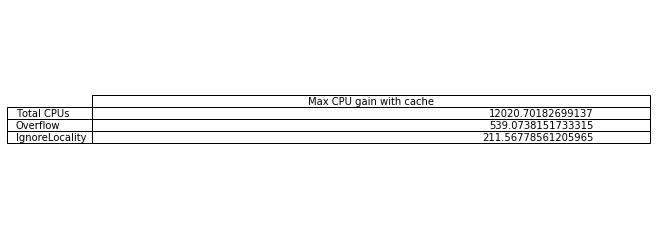

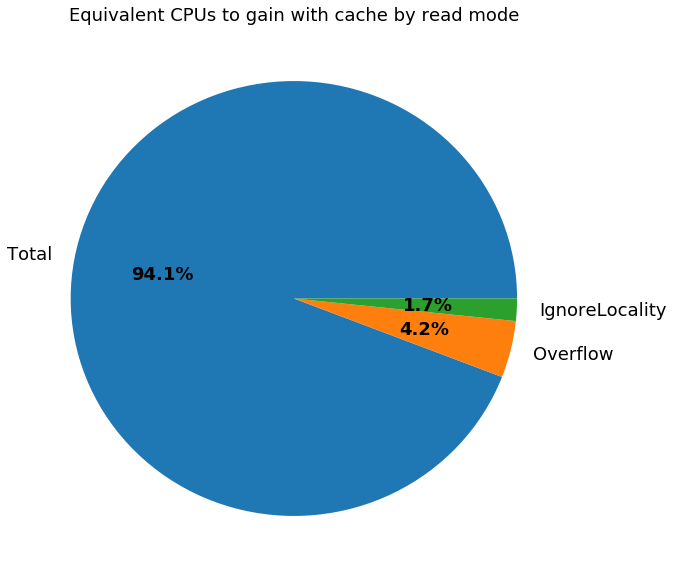

In [123]:

wall_ign = data[(data['ExitCode']>=0.0) & (data['InputData']=="Offsite") & (data['OverflowType']=='IgnoreLocality')].WallClock.sum()
cpu_ign = data[(data['ExitCode']>=0.0) & (data['InputData']=="Offsite") & (data['OverflowType']=='IgnoreLocality')].CPUTime.sum()

if not ignore_overflow:
    wall_off = data[(data['ExitCode']>=0.0) & (data['InputData']=="Offsite") & (data['OverflowType']!='IgnoreLocality')].WallClock.sum()
    cpu_off = data[(data['ExitCode']>=0.0) & (data['InputData']=="Offsite") & (data['OverflowType']!='IgnoreLocality')].CPUTime.sum()


wall = data[(data['ExitCode']>=0.0) & (data['InputData']=="Onsite")].WallClock.sum()
cpu = data[(data['ExitCode']>=0.0) & (data['InputData']=="Onsite")].CPUTime.sum()

cache_gain_ign = (wall_ign - cpu_ign)*(1-(1/((wall_ign - cpu_ign)*wall/(wall_ign*(wall - cpu)))))/total_hrs

if not ignore_overflow:
    cache_gain_off = (wall_off - cpu_off)*(1-(1/((wall_off - cpu_off)*wall/(wall_off*(wall - cpu)))))/total_hrs

if ignore_overflow:
    total = (wall+wall_ign)/total_hrs
else:
    total = (wall+wall_off+wall_ign)/total_hrs
#wall_off_tot = data[(data['ExitCode']>=0.0) & (data['InputData']=="Offsite")].WallClock.sum()
#total2 = (wall+wall_off_tot)/total_hrs

print "Total:\t\t\t", total
#print "Remote Unknown:", total2
#print "CPU Cache gain IgnoreLocality:\t", cache_gain_ign

if not ignore_overflow:
    print "CPUCache gain Overflow:\t", cache_gain_off

if not ignore_overflow:
    cpu_gain_table = pd.DataFrame({'Max CPU gain with cache': [total, cache_gain_off , cache_gain_ign]},
                           index=["Total CPUs", "Overflow","IgnoreLocality"])
else:
    cpu_gain_table = pd.DataFrame({'Max CPU gain with cache': [total, cache_gain_ign]},
                           index=["Total CPUs", "IgnoreLocality"])    

plt.figure(figsize=(10, 4))
ax2 = plt.subplot(111)
plt.axis('off')
tbl = table(ax2, cpu_gain_table, loc='center')
tbl.auto_set_font_size(True)

plt.savefig('%s/cpu_gain_by_read_mode_table.png' % name)

plt.figure(figsize=(10, 10))
if ignore_overflow:
    wedges, texts, autotexts = plt.pie([total, cache_gain_ign], labels=["Total", "IgnoreLocality"], autopct='%1.1f%%', textprops={"fontsize":18})
else:
    wedges, texts, autotexts = plt.pie([total, cache_gain_off, cache_gain_ign], labels=["Total", "Overflow", "IgnoreLocality"], autopct='%1.1f%%', textprops={"fontsize":18})

plt.setp(texts, size=18)
plt.setp(autotexts, size=18, weight="bold")
plt.title('Equivalent CPUs to gain with cache by read mode',fontdict={"fontsize":18})

plt.savefig('%s/cpu_gain_by_read_mode.png' % name)
plt.show()

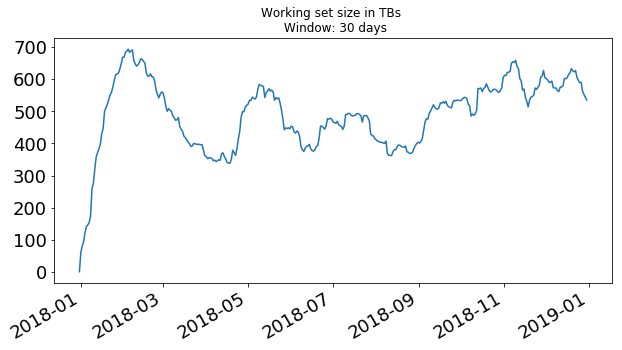

In [124]:
#print data.groupby('day').CRAB_DataBlock.unique()
def make_window_ws(df, window_in_day):
    item_sum = []
    date = start_date
    
    item_sum = []
    index = []
    while date < end_date:
        start_interval = date - datetime.timedelta(days=window)

        item_sum.append(df[(df['day'] > start_interval) & (df['day'] <= date)].CRAB_DataBlock.unique())

        index.append(date)
        
        date += datetime.timedelta(days=1)


    return pd.Series(data=item_sum, index=index)

my_f = data.groupby('day').CRAB_DataBlock.apply(pd.Series)\
              .reset_index()

block_sizes = data.groupby('CRAB_DataBlock').block_size.max()

sum_size = []
index = []
for i, test in make_window_ws(my_f, window).items():
    #print len(test)
    sum_tmp = 0
    #print i
    for block in test:
        sum_tmp += block_sizes[block]
    sum_size.append(sum_tmp)
    index.append(i)

(pd.Series(data=sum_size, index=index)/1E12).plot(title='Working set size in TBs \n Window: %s days' % window, figsize=(10, 5), fontsize=18, x_compat=True)

plt.savefig('%s/ws_size_%sd_window_allTiers.png' % (name, window))
plt.show()

In [ ]:
#data.groupby('CRAB_DataBlock').CRAB_Workflow.nunique().plot.hist(bins=20, range=(0,20), log=True) #.plot()
#plt.show()

In [ ]:
#data.groupby('CRAB_DataBlock').CRAB_UserHN.nunique().plot.hist(bins=20, range=(0,20), log=True) #.plot()
#plt.show()